In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from pycytominer.cyto_utils import infer_cp_features
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
eff = pd.read_csv("aggregated_efficientnet_median.csv", low_memory=False)
res = pd.read_csv("aggregated_resnet_median.csv", low_memory=False)

In [3]:

eff_features = [feat for feat in eff.columns if feat.startswith('eff')]
res_features = [feat for feat in res.columns if feat.startswith('res')]
eff = eff.sample(frac = 1)
res = res.sample(frac = 1)

In [4]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(eff[eff_features].values)
eff['pca_one'] = pca_result[:,0]
eff['pca_two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
pca_result = pca.fit_transform(res[res_features].values)
res['pca_one'] = pca_result[:,0]
res['pca_two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.53239571 0.15976469]
Explained variation per principal component: [0.44954394 0.18522429]


In [13]:
def is_dmso(sample):
    if sample == 'DMSO':
        return "DMSO"
    else:
        return "Perturbed"
eff['Well type'] = eff.Metadata_broad_sample.apply(is_dmso)
res['Well type'] = res.Metadata_broad_sample.apply(is_dmso)


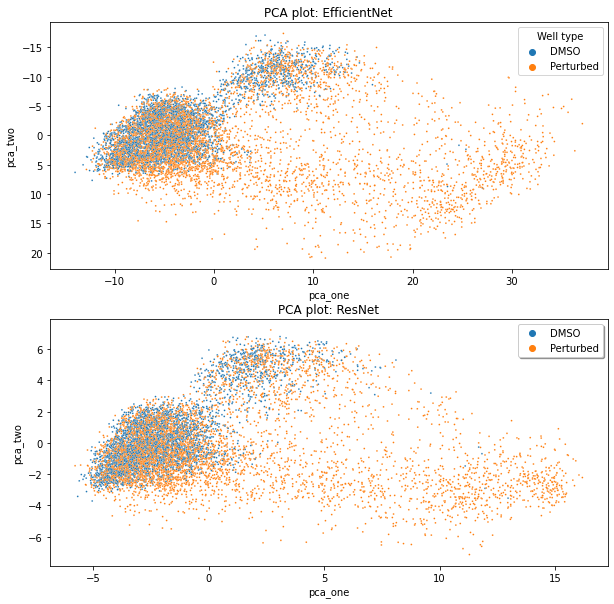

In [27]:

fig, ax =plt.subplots(2,1, figsize=(10,10))
plt.style.use({'figure.facecolor':'white'})
# plt.title("PCA plot: Pre-trained profiles ")
ax[0].title.set_text('PCA plot: EfficientNet')
ax[1].title.set_text('PCA plot: ResNet')
gfg = sns.scatterplot(data=eff, x="pca_one", y='pca_two', s = 3,ax=ax[1], hue = eff["Well type"],hue_order = ["DMSO", "Perturbed"], palette="tab10")
gfg = sns.scatterplot(data=res, x="pca_one", y='pca_two', s = 3, ax=ax[0], hue = res["Well type"],hue_order = ["DMSO", "Perturbed"], palette="tab10")

plt.legend(loc = 'upper right', shadow=True)
ax[0].invert_yaxis()
plt.show()

In [21]:
# maybe thats the batch 5?

5056    1
5021    1
8626    1
4385    1
1606    0
       ..
5910    1
2535    0
8685    1
136     0
1559    0
Name: DMSO, Length: 8733, dtype: int64

In [5]:
# Get Batch data
batch = pd.read_csv('/Users/mbornhol/git/neural-profiling/baseline/01_data/level_3_data/sub_level3.csv')
b = batch[['Metadata_Batch_Number', 'Metadata_Plate', 'Metadata_Well']]

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (8,9,16,17,18,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
eff = pd.merge(eff, b, how="left", on=['Metadata_Plate', 'Metadata_Well'])
res = pd.merge(res, b, how="left", on=['Metadata_Plate', 'Metadata_Well'])

[]

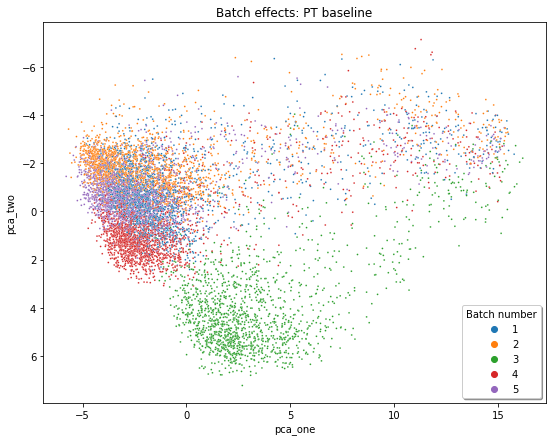

In [16]:
fig, ax = plt.subplots(figsize=(9,7))
plt.style.use({'figure.facecolor':'white'})
plt.title("Batch effects: PT baseline")
# gfg = sns.scatterplot(data=res, x="pca_one", y='pca_two', hue = res['Metadata_Batch_Number'], s = 3, ax=ax[0], palette="tab10")
gfg = sns.scatterplot(data=eff, x="pca_one", y='pca_two', hue=eff["Metadata_Batch_Number"],  s= 3,ax=ax, palette="tab10")
ax.invert_yaxis()
plt.legend(loc = 'lower right', shadow=True, title='Batch number')
plt.plot()

In [ ]:
# now normalize

In [62]:
eff_rob = normalize(
    profiles=eff,
    features=eff_features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
)

Explained variation per principal component: [0.50562739 0.10818844]


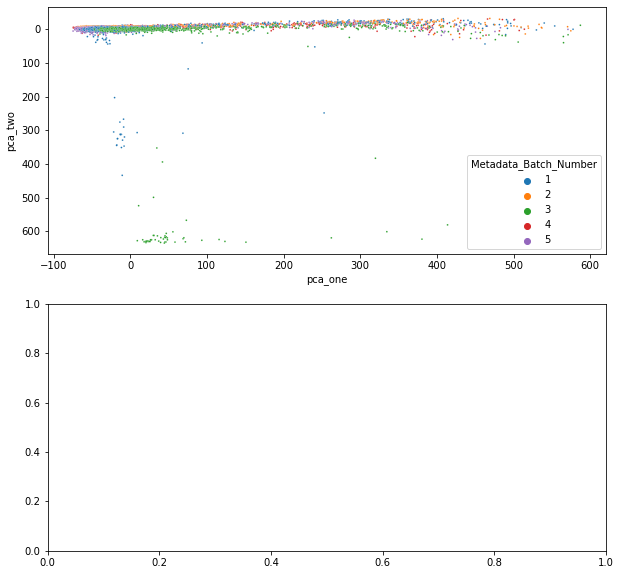

In [66]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(eff_rob[eff_features].values)
eff_rob['pca_one'] = pca_result[:,0]
eff_rob['pca_two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
fig, ax =plt.subplots(2,1, figsize=(10,10))
plt.style.use({'figure.facecolor':'white'})
gfg = sns.scatterplot(data=eff_rob, x="pca_one", y='pca_two', hue = res['Metadata_Batch_Number'], s = 3, ax=ax[0], palette="tab10")
#gfg = sns.scatterplot(data=eff, x="pca_one", y='pca_two', hue=eff["Metadata_Batch_Number"], s = 3,ax=ax[1], palette="tab10")
ax[0].invert_yaxis()

In [7]:
eff[eff_features].max().max()

4.809250116348267

In [8]:
eff[eff_features].min().min()


-0.2575585693120956

In [80]:
res[res_features].max()

resnet_0        0.449973
resnet_1        0.028190
resnet_2        3.672522
resnet_3        0.000000
resnet_4        0.168858
                  ...   
resnet_10235    0.097862
resnet_10236    1.119934
resnet_10237    0.529383
resnet_10238    1.103493
resnet_10239    0.000000
Length: 10240, dtype: float64

In [81]:
10240/5

2048.0

In [5]:
eff[eff_features].median().median()

-0.12639763951301575

(array([5.651e+03, 4.490e+02, 1.630e+02, 6.100e+01, 4.100e+01, 2.000e+01,
        8.000e+00, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.23523228,  0.14303278,  0.52129783,  0.89956288,  1.27782793,
         1.65609298,  2.03435803,  2.41262308,  2.79088813,  3.16915319,
         3.54741824]),
 <BarContainer object of 10 artists>)

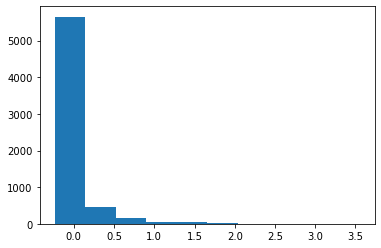

In [10]:
ls = eff[eff_features].mean()

(array([5.651e+03, 4.490e+02, 1.630e+02, 6.100e+01, 4.100e+01, 2.000e+01,
        8.000e+00, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.23523228,  0.14303278,  0.52129783,  0.89956288,  1.27782793,
         1.65609298,  2.03435803,  2.41262308,  2.79088813,  3.16915319,
         3.54741824]),
 <BarContainer object of 10 artists>)

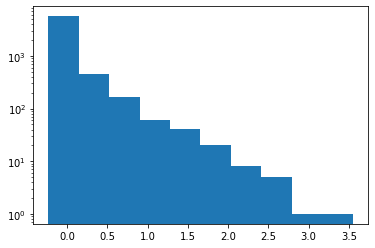

In [11]:
plt.hist(ls, log=True)